<a href="https://colab.research.google.com/github/amanjain252002/Stock-Price-Prediction/blob/main/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pmdarima

In [25]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [26]:
import statsmodels.api as sm

In [4]:
AAPL = pd.read_csv("/content/drive/MyDrive/Pre_Processed_AAPL.csv")
TSLA = pd.read_csv("/content/drive/MyDrive/Pre_Processed_TSLA.csv")
GOOG = pd.read_csv("/content/drive/MyDrive/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("/content/drive/MyDrive/Pre_Processed_MSFT.csv")
AMZN = pd.read_csv("/content/drive/MyDrive/Pre_Processed_AMZN.csv")

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series and help us understand if the series is stationary.

**Null Hypothesis**: The series has a unit root

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the Null Hypothesis, then the series is non-stationary.

In [5]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Adj. Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

#Apple

In [6]:
AAPL.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [8]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [9]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

In [10]:
Test_Stationarity(AAPL)

Results of Dickey Fuller Test
Test Statistics: 1.120722206443354
p-value: 0.9953896550774385
Number of lags used: 24
Number of observations used: 1524
critical value (1%): -3.4346481290263013
critical value (5%): -2.8634383565975736
critical value (10%): -2.567780658251872


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

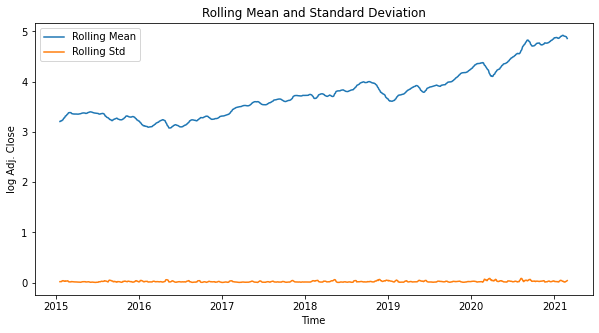

In [11]:
AAPL['log Adj. Close'] = np.log(AAPL['Adj. Close'])
AAPL_log_moving_avg = AAPL['log Adj. Close'].rolling(12).mean()
AAPL_log_std = AAPL['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(AAPL['Date'], AAPL_log_moving_avg, label = "Rolling Mean")
plt.plot(AAPL['Date'], AAPL_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set

    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26







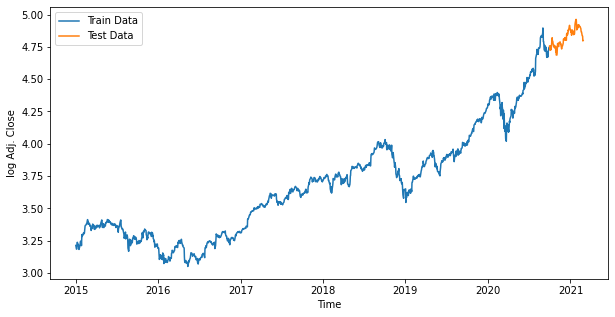

In [12]:
AAPL_Train_Data = AAPL[AAPL['Date'] < '2020-10-01']
AAPL_Test_Data = AAPL[AAPL['Date'] >= '2020-10-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(AAPL_Train_Data['Date'], AAPL_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(AAPL_Test_Data['Date'], AAPL_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [13]:
AAPL_Auto_ARIMA_Model = auto_arima(AAPL_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(AAPL_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3721.627
Date:                Thu, 24 Mar 2022   AIC                          -7437.254
Time:                        00:57:01   BIC                          -7421.424
Sample:                             0   HQIC                         -7431.346
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      2.366      0.018       0.000       0.002
ar.L1         -0.0981      0.015     -6.535      0.000      -0.127      -0.069
sigma2         0.0003   6.51e-06     52.314      0.0

In [27]:
AAPL_ARIMA_Model = sm.tsa.arima.ARIMA(AAPL_Train_Data['log Adj. Close'], order = (1, 1, 0))
AAPL_ARIMA_Model_Fit = AAPL_ARIMA_Model.fit()
print(AAPL_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1447
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3718.749
Date:                Thu, 24 Mar 2022   AIC                          -7433.498
Time:                        01:02:36   BIC                          -7422.945
Sample:                             0   HQIC                         -7429.560
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0944      0.015     -6.302      0.000      -0.124      -0.065
sigma2         0.0003   6.51e-06     52.451      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

###Predicting the closing stock price of Apple

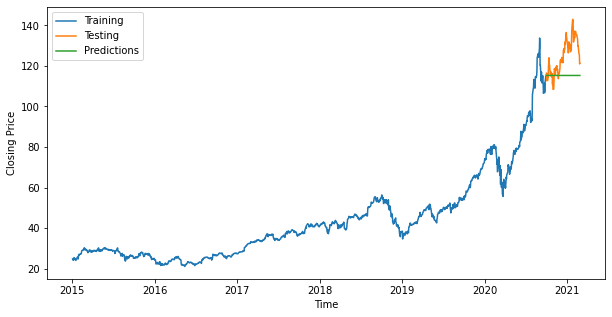

In [34]:
AAPL_output = AAPL_ARIMA_Model_Fit.forecast(102, alpha=0.05)
AAPL_predictions = np.exp(AAPL_output)
plt.figure(figsize=(10, 5))
plt.plot(AAPL_Train_Data['Date'], AAPL_Train_Data['Adj. Close'], label = 'Training')
plt.plot(AAPL_Test_Data['Date'], AAPL_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(AAPL_Test_Data['Date'], AAPL_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Data['Adj. Close'], AAPL_predictions))
mape = np.mean(np.abs(AAPL_predictions - AAPL_Test_Data['Adj. Close'])/np.abs(AAPL_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 12.483579700355461
MAPE: nan


#Tesla

In [ ]:
TSLA.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,44.57,44.65,42.65,43.86,43.86,23822000.0
1,2015-01-05,42.91,43.30,41.43,42.02,42.02,26842500.0
2,2015-01-06,42.01,42.84,40.84,42.26,42.26,31309500.0
3,2015-01-07,42.67,42.96,41.96,42.19,42.19,14842000.0
4,2015-01-08,42.56,42.76,42.00,42.12,42.12,17212500.0


In [ ]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [ ]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

In [ ]:
Test_Stationarity(TSLA)

Results of Dickey Fuller Test
Test Statistics: 0.399800627348111
p-value: 0.9814874842817937
Number of lags used: 24
Number of observations used: 1524
critical value (1%): -3.4346481290263013
critical value (5%): -2.8634383565975736
critical value (10%): -2.567780658251872


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

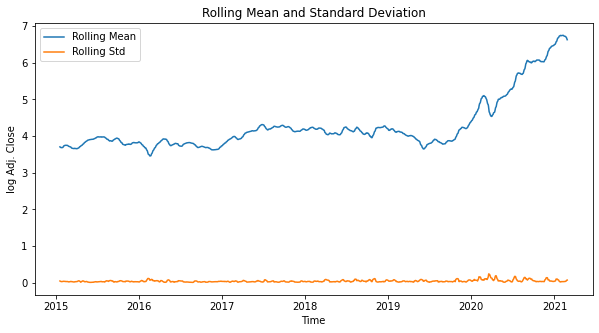

In [ ]:
TSLA['log Adj. Close'] = np.log(TSLA['Adj. Close'])
TSLA_log_moving_avg = TSLA['log Adj. Close'].rolling(12).mean()
TSLA_log_std = TSLA['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(TSLA['Date'], TSLA_log_moving_avg, label = "Rolling Mean")
plt.plot(TSLA['Date'], TSLA_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

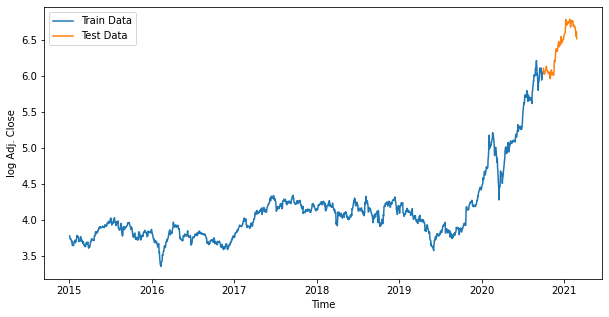

In [ ]:
TSLA_Train_Data = TSLA[TSLA['Date'] < '2020-10-01']
TSLA_Test_Data = TSLA[TSLA['Date'] >= '2020-10-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(TSLA_Train_Data['Date'], TSLA_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(TSLA_Test_Data['Date'], TSLA_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
TSLA_Auto_ARIMA_Model = auto_arima(TSLA_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(TSLA_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(5, 2, 2)   Log Likelihood                2803.027
Date:                Wed, 23 Mar 2022   AIC                          -5588.054
Time:                        23:53:21   BIC                          -5540.572
Sample:                             0   HQIC                         -5570.332
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    5.57e-06   3.99e-05      0.140      0.889   -7.26e-05    8.38e-05
ar.L1         -0.6953      3.960     -0.176      0.861      -8.456       7.065
ar.L2          0.0466      0.104      0.447      0.6

In [ ]:
TSLA_ARIMA_Model = ARIMA(TSLA_Train_Data['log Adj. Close'], order = (5, 2, 2))
TSLA_ARIMA_Model_Fit = TSLA_ARIMA_Model.fit()
print(TSLA_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1447
Model:                 ARIMA(5, 2, 2)   Log Likelihood                2810.935
Date:                Wed, 23 Mar 2022   AIC                          -5605.870
Time:                        23:53:23   BIC                          -5563.663
Sample:                             0   HQIC                         -5590.117
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8508      0.438     -1.942      0.052      -1.710       0.008
ar.L2          0.0491      0.022      2.238      0.025       0.006       0.092
ar.L3          0.0709      0.027      2.636      0.0

###Predicting the closing stock price of Tesla

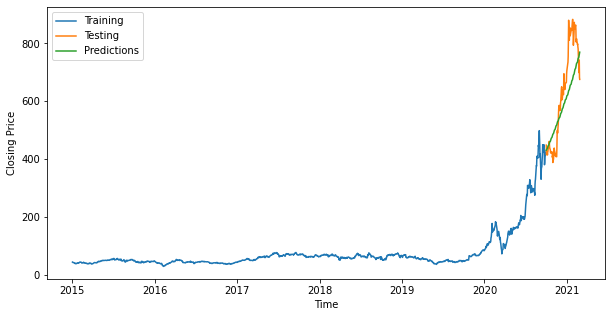

In [ ]:
TSLA_output = TSLA_ARIMA_Model_Fit.forecast(102, alpha=0.05)
TSLA_predictions = np.exp(TSLA_output)
plt.figure(figsize=(10, 5))
plt.plot(TSLA_Train_Data['Date'], TSLA_Train_Data['Adj. Close'], label = 'Training')
plt.plot(TSLA_Test_Data['Date'], TSLA_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(TSLA_Test_Data['Date'], TSLA_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Data['Adj. Close'], TSLA_predictions))
mape = np.mean(np.abs(TSLA_predictions - TSLA_Test_Data['Adj. Close'])/np.abs(TSLA_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 99.9329822498403
MAPE: nan


#Google

In [ ]:
GOOG.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,527.56,529.82,522.67,523.37,523.37,1447563.0
1,2015-01-05,521.83,522.89,511.66,512.46,512.46,2059840.0
2,2015-01-06,513.59,514.76,499.68,500.59,500.59,2899940.0
3,2015-01-07,505.61,505.86,498.28,499.73,499.73,2065054.0
4,2015-01-08,496.63,502.10,489.66,501.30,501.30,3353582.0


In [ ]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [ ]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

In [ ]:
Test_Stationarity(GOOG)

Results of Dickey Fuller Test
Test Statistics: 0.6722962942047419
p-value: 0.9892684650395426
Number of lags used: 22
Number of observations used: 1526
critical value (1%): -3.4346424863111396
critical value (5%): -2.8634358661653803
critical value (10%): -2.5677793320839823


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

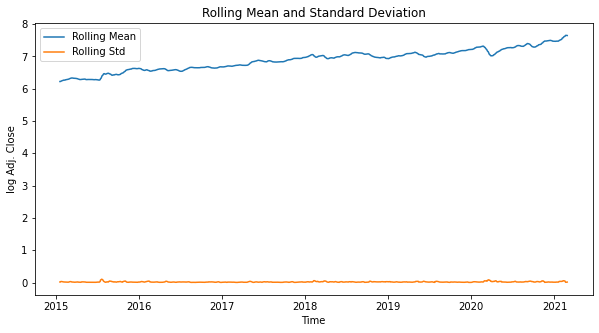

In [ ]:
GOOG['log Adj. Close'] = np.log(GOOG['Adj. Close'])
GOOG_log_moving_avg = GOOG['log Adj. Close'].rolling(12).mean()
GOOG_log_std = GOOG['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(GOOG['Date'], GOOG_log_moving_avg, label = "Rolling Mean")
plt.plot(GOOG['Date'], GOOG_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

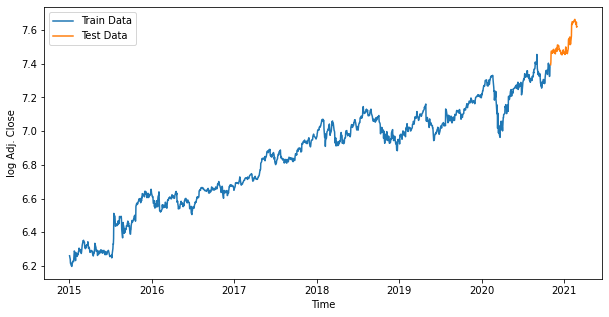

In [ ]:
GOOG_Train_Data = GOOG[GOOG['Date'] < '2020-11-01']
GOOG_Test_Data = GOOG[GOOG['Date'] >= '2020-11-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(GOOG_Train_Data['Date'], GOOG_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(GOOG_Test_Data['Date'], GOOG_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
GOOG_Auto_ARIMA_Model = auto_arima(GOOG_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(GOOG_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1469
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3905.939
Date:                Wed, 23 Mar 2022   AIC                          -7805.878
Time:                        23:54:45   BIC                          -7790.003
Sample:                             0   HQIC                         -7799.958
                               - 1469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      1.882      0.060   -3.47e-05       0.002
ar.L1         -0.0876      0.015     -5.798      0.000      -0.117      -0.058
sigma2         0.0003   4.48e-06     63.886      0.0

In [ ]:
GOOG_ARIMA_Model = ARIMA(GOOG_Train_Data['log Adj. Close'], order = (1, 1, 0))
GOOG_ARIMA_Model_Fit = GOOG_ARIMA_Model.fit()
print(GOOG_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1469
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3904.148
Date:                Wed, 23 Mar 2022   AIC                          -7804.296
Time:                        23:54:45   BIC                          -7793.712
Sample:                             0   HQIC                         -7800.349
                               - 1469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0854      0.015     -5.640      0.000      -0.115      -0.056
sigma2         0.0003   4.48e-06     63.960      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

###Predicting the closing stock price of Google

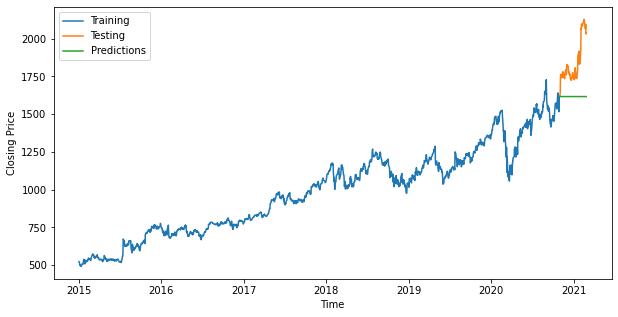

In [ ]:
GOOG_output = GOOG_ARIMA_Model_Fit.forecast(80, alpha=0.05)
GOOG_predictions = np.exp(GOOG_output)
plt.figure(figsize=(10, 5))
plt.plot(GOOG_Train_Data['Date'], GOOG_Train_Data['Adj. Close'], label = 'Training')
plt.plot(GOOG_Test_Data['Date'], GOOG_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(GOOG_Test_Data['Date'], GOOG_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Data['Adj. Close'], GOOG_predictions))
mape = np.mean(np.abs(GOOG_predictions - GOOG_Test_Data['Adj. Close'])/np.abs(GOOG_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 265.8827661905126
MAPE: nan


#Microsoft

In [ ]:
MSFT.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,46.66,47.42,46.54,46.76,41.44,27913900.0
1,2015-01-05,46.37,46.73,46.25,46.33,41.06,39673900.0
2,2015-01-06,46.38,46.75,45.54,45.65,40.46,36447900.0
3,2015-01-07,45.98,46.46,45.49,46.23,40.97,29114100.0
4,2015-01-08,46.75,47.75,46.72,47.59,42.18,29645200.0


In [ ]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [ ]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

In [ ]:
Test_Stationarity(MSFT)

Results of Dickey Fuller Test
Test Statistics: 2.1271168914605796
p-value: 0.9988169756931882
Number of lags used: 24
Number of observations used: 1524
critical value (1%): -3.4346481290263013
critical value (5%): -2.8634383565975736
critical value (10%): -2.567780658251872


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

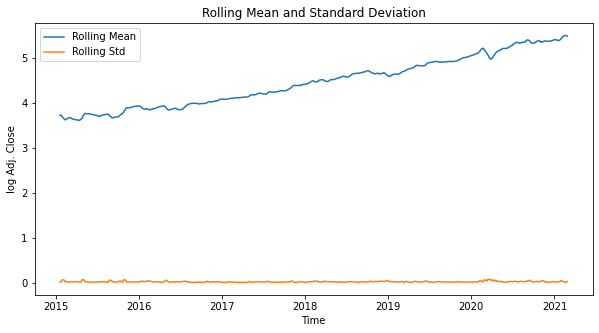

In [ ]:
MSFT['log Adj. Close'] = np.log(MSFT['Adj. Close'])
MSFT_log_moving_avg = MSFT['log Adj. Close'].rolling(12).mean()
MSFT_log_std = MSFT['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(MSFT['Date'], MSFT_log_moving_avg, label = "Rolling Mean")
plt.plot(MSFT['Date'], MSFT_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

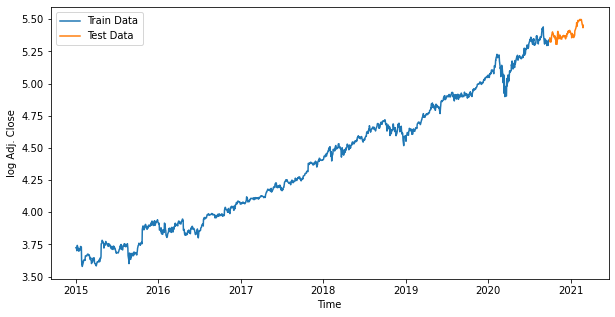

In [ ]:
MSFT_Train_Data = MSFT[MSFT['Date'] < '2020-10-01']
MSFT_Test_Data = MSFT[MSFT['Date'] >= '2020-10-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(MSFT_Train_Data['Date'], MSFT_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(MSFT_Test_Data['Date'], MSFT_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
MSFT_Auto_ARIMA_Model = auto_arima(MSFT_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(MSFT_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3828.056
Date:                Wed, 23 Mar 2022   AIC                          -7650.112
Time:                        23:54:50   BIC                          -7634.282
Sample:                             0   HQIC                         -7644.204
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.000      2.995      0.003       0.000       0.002
ar.L1         -0.2169      0.012    -18.786      0.000      -0.239      -0.194
sigma2         0.0003   5.01e-06     58.650      0.0

In [ ]:
MSFT_ARIMA_Model = ARIMA(MSFT_Train_Data['log Adj. Close'], order = (1, 1, 0))
MSFT_ARIMA_Model_Fit = MSFT_ARIMA_Model.fit()
print(MSFT_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1447
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3823.523
Date:                Wed, 23 Mar 2022   AIC                          -7643.046
Time:                        23:54:50   BIC                          -7632.493
Sample:                             0   HQIC                         -7639.107
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2120      0.012    -18.278      0.000      -0.235      -0.189
sigma2         0.0003   5.06e-06     58.372      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.07   Jarque-

###Predicting the closing stock price of Microsoft

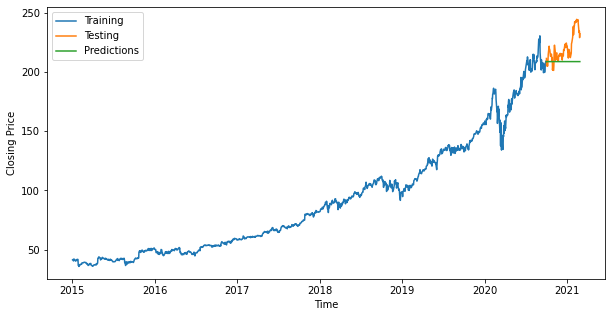

In [ ]:
MSFT_output = MSFT_ARIMA_Model_Fit.forecast(102, alpha=0.05)
MSFT_predictions = np.exp(MSFT_output)
plt.figure(figsize=(10, 5))
plt.plot(MSFT_Train_Data['Date'], MSFT_Train_Data['Adj. Close'], label = 'Training')
plt.plot(MSFT_Test_Data['Date'], MSFT_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(MSFT_Test_Data['Date'], MSFT_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Data['Adj. Close'], MSFT_predictions))
mape = np.mean(np.abs(MSFT_predictions - MSFT_Test_Data['Adj. Close'])/np.abs(MSFT_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 16.195215291646587
MAPE: nan


#Amazon

In [ ]:
AMZN.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200.0
1,2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200.0
2,2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000.0
3,2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300.0
4,2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400.0


In [ ]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [ ]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

In [ ]:
Test_Stationarity(AMZN)

Results of Dickey Fuller Test
Test Statistics: 0.270340963440495
p-value: 0.9759420712303005
Number of lags used: 18
Number of observations used: 1530
critical value (1%): -3.434631245212095
critical value (5%): -2.8634309048528066
critical value (10%): -2.5677766901619035


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

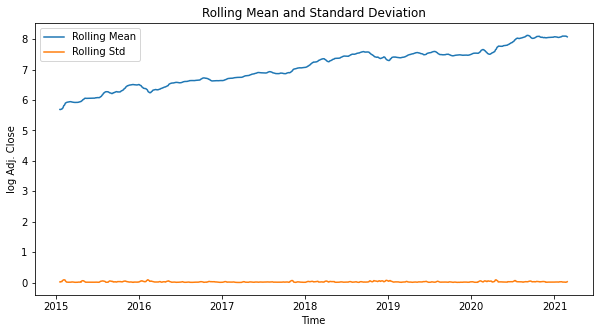

In [ ]:
AMZN['log Adj. Close'] = np.log(AMZN['Adj. Close'])
AMZN_log_moving_avg = AMZN['log Adj. Close'].rolling(12).mean()
AMZN_log_std = AMZN['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(AMZN['Date'], AMZN_log_moving_avg, label = "Rolling Mean")
plt.plot(AMZN['Date'], AMZN_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

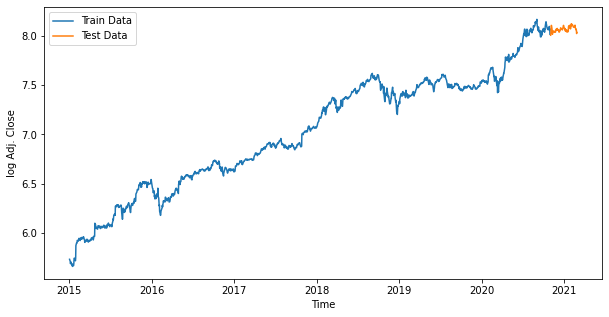

In [ ]:
AMZN_Train_Data = AMZN[AMZN['Date'] < '2020-11-01']
AMZN_Test_Data = AMZN[AMZN['Date'] >= '2020-11-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(AMZN_Train_Data['Date'], AMZN_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(AMZN_Test_Data['Date'], AMZN_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [ ]:
AMZN_Auto_ARIMA_Model = auto_arima(AMZN_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(AMZN_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1469
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3704.612
Date:                Wed, 23 Mar 2022   AIC                          -7405.225
Time:                        23:55:21   BIC                          -7394.641
Sample:                             0   HQIC                         -7401.278
                               - 1469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      3.025      0.002       0.001       0.003
sigma2         0.0004   6.92e-06     54.419      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.40   Jarque-

In [ ]:
AMZN_ARIMA_Model = ARIMA(AMZN_Train_Data['log Adj. Close'], order = (0, 1, 0))
AMZN_ARIMA_Model_Fit = AMZN_ARIMA_Model.fit()
print(AMZN_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:         log Adj. Close   No. Observations:                 1469
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3699.895
Date:                Wed, 23 Mar 2022   AIC                          -7397.791
Time:                        23:55:22   BIC                          -7392.499
Sample:                             0   HQIC                         -7395.817
                               - 1469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004    6.8e-06     55.650      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):              2529.69
Prob(Q):                              0.24   Pr

###Predicting the closing stock price of Amazon

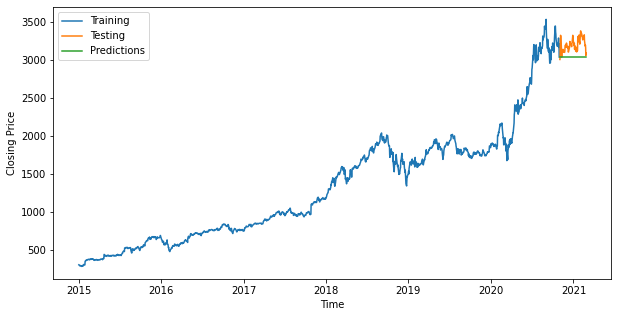

In [ ]:
AMZN_output = AMZN_ARIMA_Model_Fit.forecast(80, alpha=0.05)
AMZN_predictions = np.exp(AMZN_output)
plt.figure(figsize=(10, 5))
plt.plot(AMZN_Train_Data['Date'], AMZN_Train_Data['Adj. Close'], label = 'Training')
plt.plot(AMZN_Test_Data['Date'], AMZN_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(AMZN_Test_Data['Date'], AMZN_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [ ]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Data['Adj. Close'], AMZN_predictions))
mape = np.mean(np.abs(AMZN_predictions - AMZN_Test_Data['Adj. Close'])/np.abs(AMZN_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 184.39516145360327
MAPE: nan
